<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Film Junky Union
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Modelo de Clasificación de Reseñas de Películas
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Con esta herramienta, buscan automatizar la detección de críticas negativas dentro de su plataforma.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Objetivo del Proyecto:</p>
<p style="color: #000000; font-size: 18px;">
El objetivo es entrenar un modelo que clasifique automáticamente las reseñas de películas de IMDB como positivas o negativas. El modelo debe alcanzar una puntuación F1 de al menos 0.85 sobre el conjunto de prueba.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Diccionario de Datos:</p>
<p style="color: #000000; font-size: 18px;">
Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). <i>Learning Word Vectors for Sentiment Analysis</i>. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).
</p>

<p style="color: #000000; font-size: 18px;">Aquí se describen los campos seleccionados:</p>
<ul style="color: #000000; font-size: 18px;">
    <li><b>review</b>: el texto de la reseña</li>
    <li><b>pos</b>: el objetivo, '0' para negativo y '1' para positivo</li>
    <li><b>ds_part</b>: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente</li>
</ul>

## Inicialización

In [5]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

from lightgbm import LGBMClassifier

import torch
import transformers

import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Cargar datos

In [8]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
df_reviews.sample(10)

tconst    title_type       primary_title      original_title  \
31525  tt0069291         movie    Snowball Express    Snowball Express   
1415   tt0120613         movie  A Walk on the Moon  A Walk on the Moon   
7405   tt0084395         movie       Class Reunion       Class Reunion   
9753   tt0063893      tvSeries        Department S        Department S   
47260  tt0120907         movie            eXistenZ            eXistenZ   
47152  tt0174360         video    Zombie Bloodbath    Zombie Bloodbath   
18672  tt0085037  tvMiniSeries           Jane Eyre           Jane Eyre   
28515  tt0082992         movie     Rich and Famous     Rich and Famous   
34814  tt0051418         movie            The Blob            The Blob   
34196  tt0064027         movie     The Angry Breed     The Angry Breed   

       start_year end_year runtime_minutes  is_adult                  genres  \
31525        1972       \N              93         0           Comedy,Family   
1415         1999       \N             107         0           Drama,Romance   
7405         1982       \N              84         0           Comedy,Horror   
9753         1969     1970              60         0  Action,Adventure,Crime   
47260        1999       \N              97         0  Horror,Sci-Fi,Thriller   
47152        1993       \N              70         0           Comedy,Horror   
18672        1983     1983             239         0           Drama,Romance   
28515        1981       \N             117         0                   Drama   
34814        1958       \N              86         0           Horror,Sci-Fi   
34196        1968       \N              94         0                   Drama   

       average_rating  votes  \
31525             6.5   1438   
1415              6.6   7799   
7405              4.8   1888   
9753              7.0    383   
47260             6.8  91631   
47152             3.4    378   
18672             8.0   3074   
28515             5.9   1494   
34814             6.4  22058   
34196             5.0     79   

                                                  review  rating   sp  pos  \
31525  Based on the comments made so far, everyone se...       3  neg    0   
1415   Seeing as the world snooker championship final...       4  neg    0   
7405   National Lampoon's Class Reunion is a classic ...       9  pos    1   
9753   Spawned by the same Monty Berman / Dennis Spoo...       7  pos    1   
47260  The movie eXistenZ is about a futuristic video...       7  pos    1   
47152  A meltdown at a nuclear power plant causes a m...       8  pos    1   
18672  Jane Eyre has always been my favorite novel! W...      10  pos    1   
28515  George Cuckor, known as a director of women, c...      10  pos    1   
34814  Absolutely the very first film that scared me ...       8  pos    1   
34196  This is one of those movies that apparently wa...       1  neg    0   

      ds_part    idx  
31525    test  11653  
1415    train  12122  
7405    train   5446  
9753     test    889  
47260    test   1972  
47152   train   5768  
18672   train   9157  
28515    test   3113  
34814   train   8916  
34196   train  12363

In [11]:
df_reviews.describe()

start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.000000      0.000000        7.100000  1.397400e+04      9.000000   
max     2010.000000      1.000000        9.700000  1.739448e+06     10.000000   

                pos           idx  
count  47331.000000  47331.000000  
mean       0.498954   6279.697999  
std        0.500004   3605.702545  
min        0.000000      0.000000  
25%        0.000000   3162.000000  
50%        0.000000   6299.000000  
75%        1.000000   9412.000000  
max        1.000000  12499.000000

Hay dos valores ausentes en las culumas `average_rating` y `votes` serán eliminados. 
Los tipos de datos son correctos. Profundizaremos en el análisis de cada columna de ser necesario, de momento, se eliminarán valores ausentes y buscarán duplicados.

In [12]:
# Delete NaNs
df_reviews = df_reviews.dropna()

In [13]:
# Find Duplicates 
print('Total duplicates:', df_reviews.duplicated().sum())

Total duplicates: 0


## Exploratory Data Analysis (EDA) 

Veamos el número de películas y reseñas a lo largo de los años.

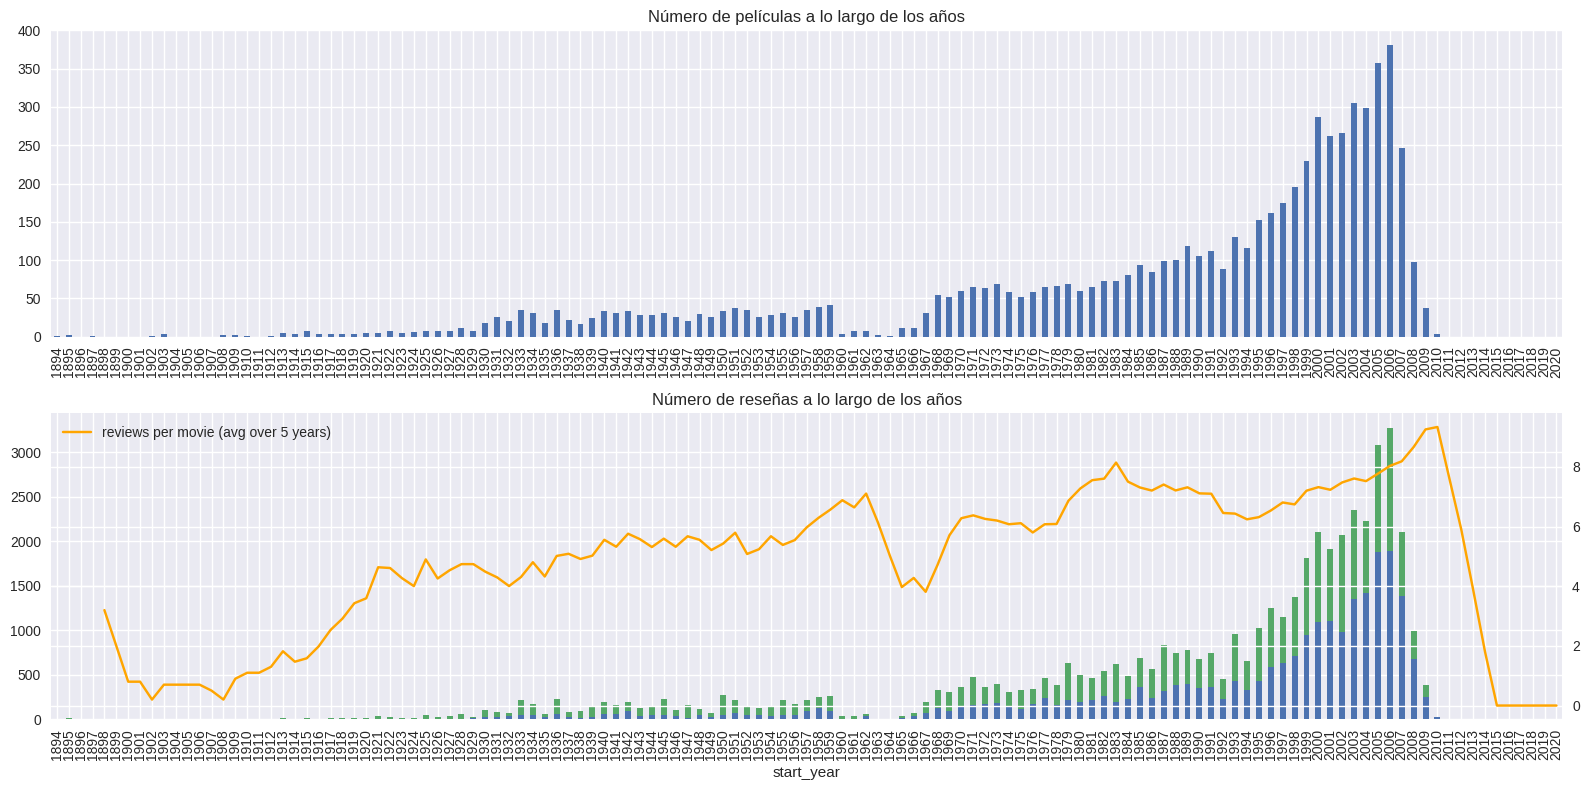

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Análisis de los gráficos:** La cantidad de reseñas por película presenta un comportamiento similar al de la producción de películas por año. Como se mostró en las gráficas anteriores, hay un aumento constante desde 1930 hasta 1959. Posteriormente, se registra una caída que se revierte en 1967, cuando la tendencia vuelve a subir. A partir de ese punto, el crecimiento continúa hasta alcanzar su punto máximo en 2006. Luego de ese año, tanto el número de películas como el de reseñas comienza a disminuir.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

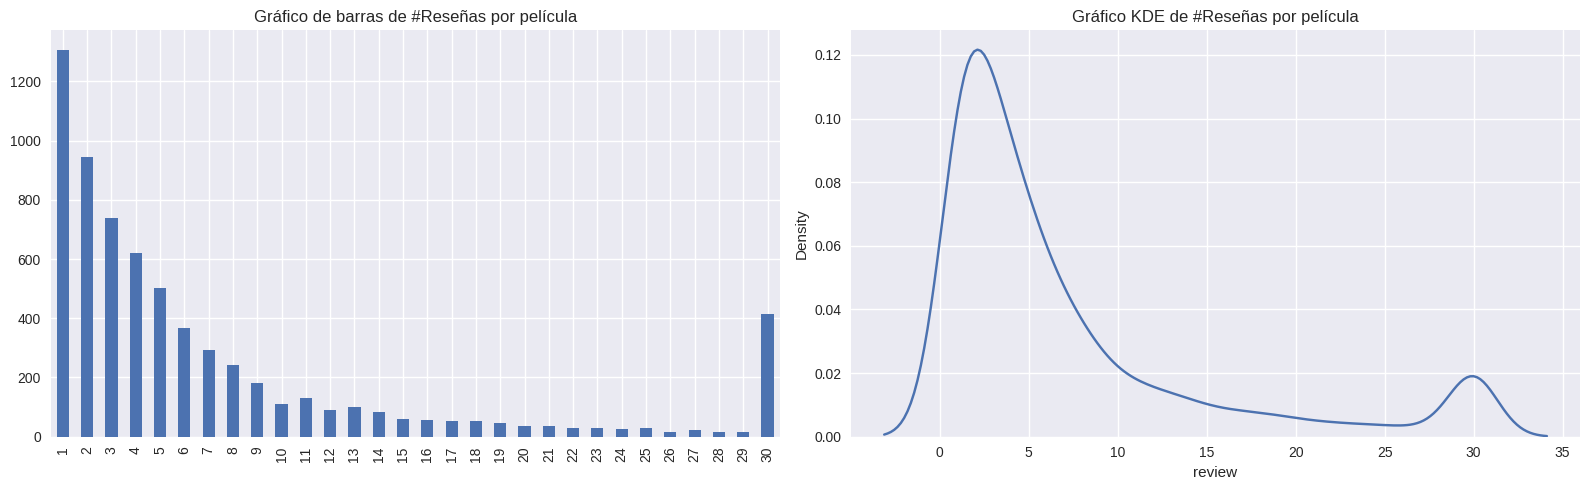

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Análisis de los gráficos:** La mayoría de las películas cuentan con solo una reseña y, a medida que el número de reseñas incrementa, la cantidad de películas disminuye. No obstante, se destaca un grupo considerable de películas que alcanzan las 30 reseñas.

In [91]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

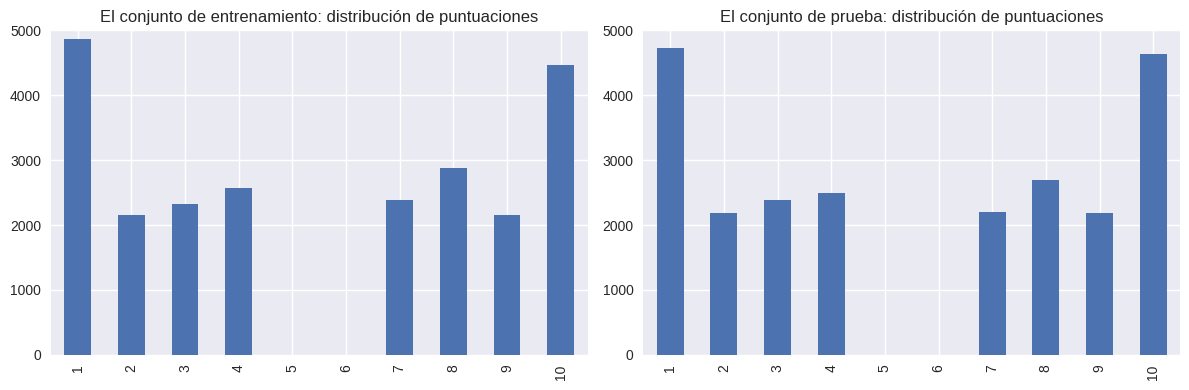

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Análisis de los gráficos:** Las distribuciones de las calificaciones son bastante uniformes, por lo que no existe un desequilibrio entre las clases en los valores de **calificación**.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

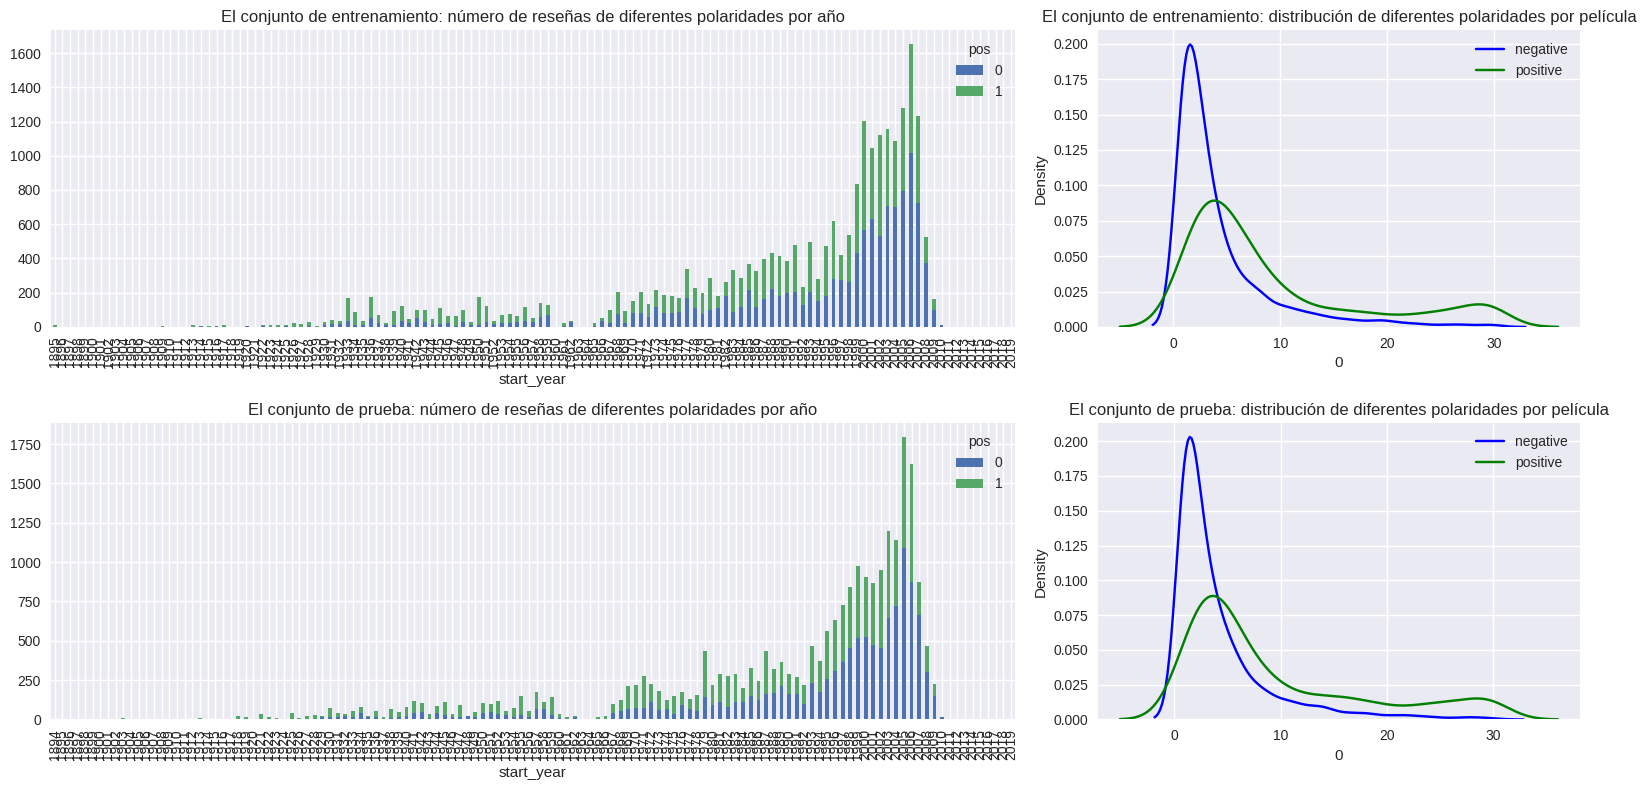

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**Análisis de los gráficos:** Las gráficas previas reflejan patrones parecidos. En ambas se nota que las reseñas negativas son ligeramente más numerosas que las positivas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [94]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [95]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [96]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [97]:
# Set lemmatizer
lemmatizer = WordNetLemmatizer()

# Set stop words
stop_words = set(stopwords.words('english'))

# Function to lemmatize
def lem_nltk(df_column, lemmatizer, stop_words):
    list = []
    for review in df_column:
        # tokenize
        tokens = word_tokenize(review)
        
        # Remove stop words
        tokens_stop = [token for token in tokens if not token in stop_words]
        
        # Lemmatize tokens without stop words
        lemmas = [lemmatizer.lemmatize(token) for token in tokens_stop]
        lemmas_joined = " ".join(lemmas)
        list.append(lemmas_joined)
        
    return list

In [98]:
# Create features for the training set
train_features0 = lem_nltk(df_reviews_train['review_norm'], lemmatizer, stop_words)

# Create features for the test set
test_features0 = lem_nltk(df_reviews_test['review_norm'], lemmatizer, stop_words)

In [99]:
# Create and train the model
model_0 = DummyClassifier().fit(train_features0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


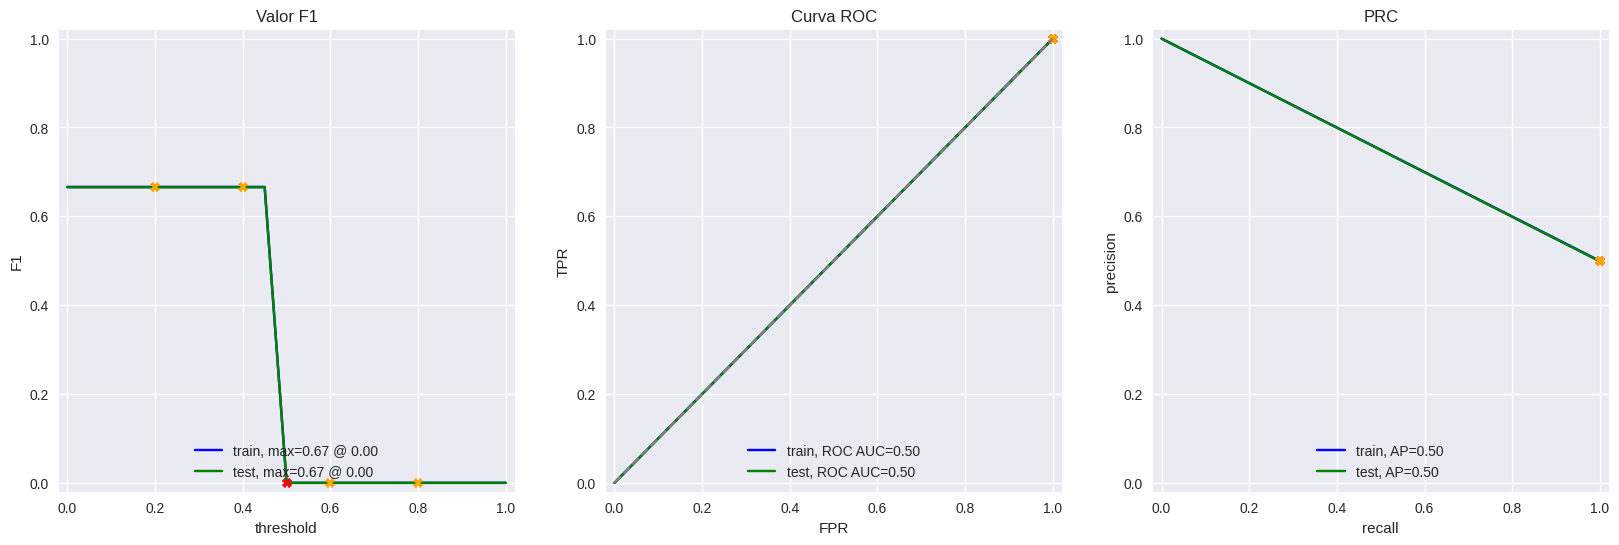

In [100]:
# Evaluate model
evaluate_model(model_0, train_features0, train_target, test_features0, test_target)

**Comentarios:**     
Tiene sentido que la puntuación F1 sea 0, ya que este modelo constante no logra identificar correctamente los casos en los que `pos` es igual a 1.   
Esperemos que los siguientes modelos tengan mejores resultados en todas las métricas.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [101]:
# Create features for the training set
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words))
train_features_1 = count_tf_idf.fit_transform(train_features0) 

# Create features for the test set
test_features_1 = count_tf_idf.transform(test_features0) 

# Create and train model
model_1 = LogisticRegression(random_state=12345) 
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


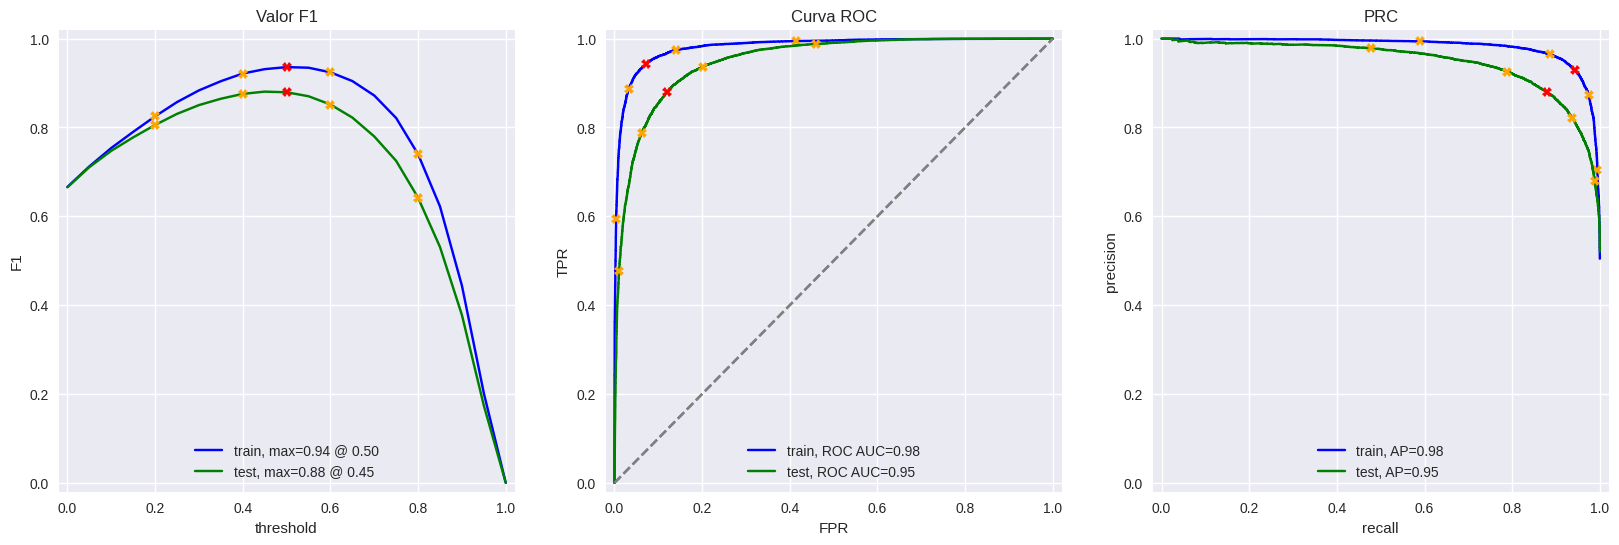

In [102]:
# Evaluate model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**Comentarios:** Todas las métricas superan a las del modelo dummy y se cumple que el valor F1 es superior a 0.85.

### Modelo 3 - spaCy, TF-IDF y LR

In [103]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [104]:
# Function for lemmatizing with spacy
def lem_spacy(df_column):
    lemmatized_reviews = []
    for review in df_column:
        doc = nlp(review)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        lemmatized_reviews.append(' '.join(tokens))
    return lemmatized_reviews

In [105]:
# Lemmatize training set
train_spacy2 = lem_spacy(df_reviews_train['review_norm'])
# Lemmatize test set
test_spacy2 = lem_spacy(df_reviews_test['review_norm'])
count_tf_idf_spacy = TfidfVectorizer()

In [106]:
# Features for the training set
train_features_2 = count_tf_idf_spacy.fit_transform(train_spacy2) 
# Features for the test set
test_features_2 = count_tf_idf_spacy.transform(test_spacy2)

In [107]:
# Create the model and train it
model_2 = LogisticRegression(random_state=12345) 
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


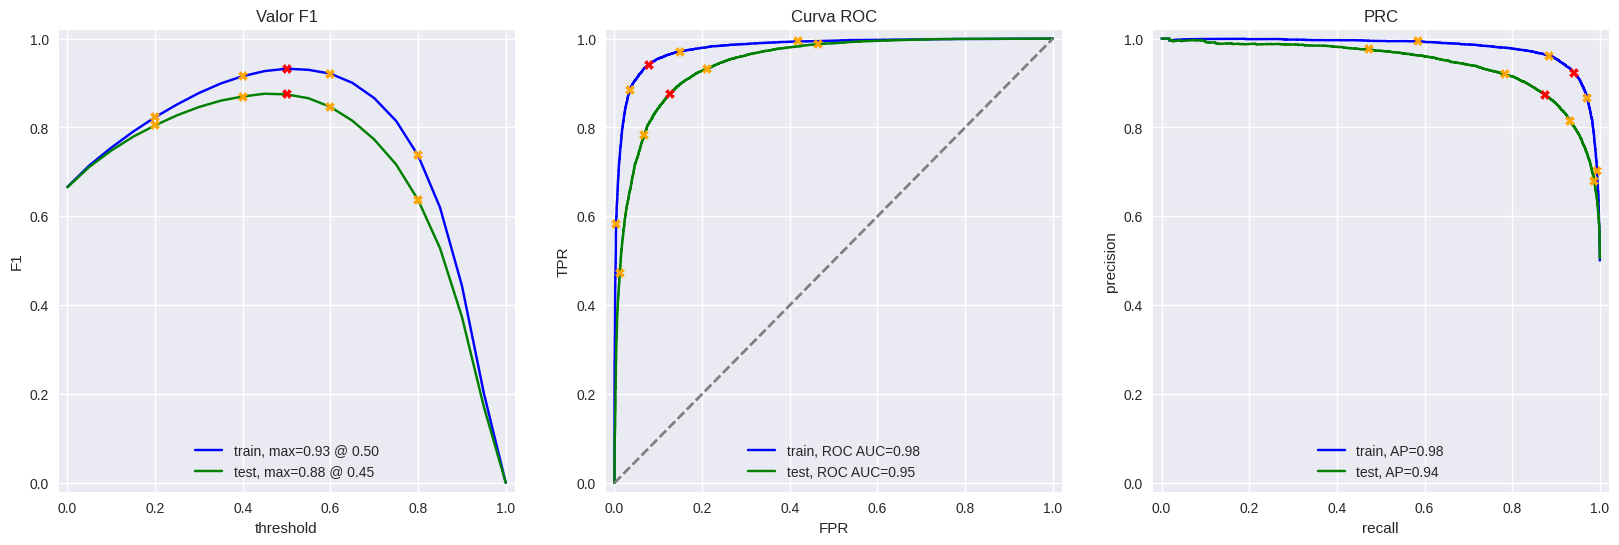

In [113]:
# Evaluate Model
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

**Comentarios:**  Los resultados son elevados, aunque los del modelo de regresión logística utilizando NLTK siguen dando mejores resultados.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier con GridSearchCV

In [114]:
# Find best parameters
parameters={'num_leaves':[10, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 40, 60],
            'objective':['binary'], 'random_state':[12345]}

grid=GridSearchCV(estimator=LGBMClassifier(), param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_2, train_target)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1],
                         'n_estimators': [10, 20, 40, 60],
                         'num_leaves': [10, 20], 'objective': ['binary'],
                         'random_state': [12345]},
             scoring='f1')

In [115]:
# Create and train model
model_3 = grid.best_estimator_
model_3.fit(train_features_2, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=60, num_leaves=20,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.94  0.85
F1         0.94  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


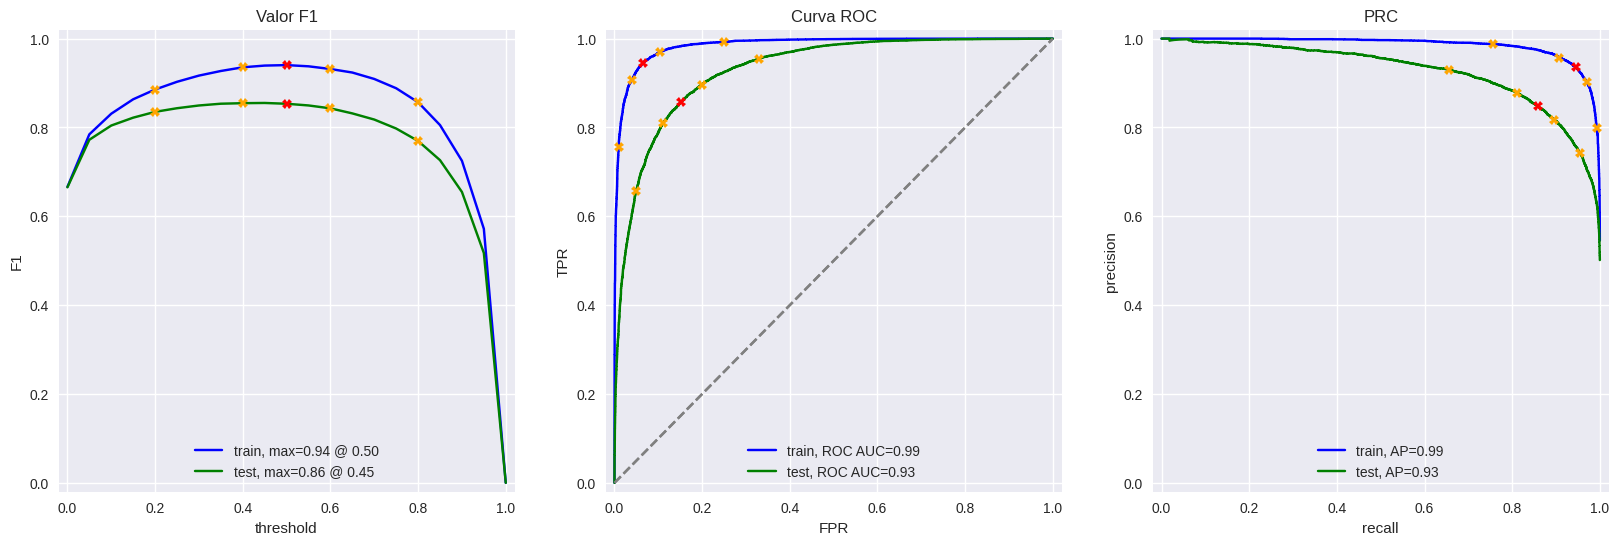

In [116]:
# Evaluate Model
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

**Comentarios:** El modelo de regresión logística utilizando NLTK siguen dando mejores resultados en los modelos entrenados.

## Mis reseñas

In [121]:
# Reviews 

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# Normalization: Convert text to lowercase, retain only alphabetic characters, and remove extra whitespace using strip()
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

my_reviews

review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0     i did not simply like it  not my kind of movie  
1  well  i was bored and felt asleep in the middl...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn t expect the reboot to be so good  writ...  
5  the movie had its upsides and downsides  but i...  
6  what a rotten attempt at a comedy  not a singl...  
7  launching on netflix was a brave move   i real...

El dataframe `my_reviews` tiene 8 reseñas:

- Las reseñas 0, 1, 3, 6 son **negativas**.
- Las reseñas 2, 4, 5, 7 son **positivas**.

Sin embargo, la reseña 6 es más bien "algo positiva". El autor la describe como "decente" y menciona que "podría volver a verla", aunque también señala que la película tiene "puntos negativos".

No me sorprendería que los modelos tengan dificultades para clasificar correctamente la reseña 5.

### Modelo 1

In [126]:
# Extract normalized reviews from the 'my_reviews' DataFrame
texts = my_reviews['review_norm']

# Predict probabilities for the positive class using model_1 and TF-IDF transformed data
my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it  not my kind of movie
0.16:  well  i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.35:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.88:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Resultados**:La reseña número 4 fue etiquetada como negativa, aunque en realidad es positiva. Lo mismo ocurrió con la reseña número 5, que está muy cerca de ser clasificada como positiva, pero el contenido no es completamente favorable.

### Modelo 2

In [127]:
# Lemmatize the normalized reviews using SpaCy
my_rev_spacy = lem_spacy(my_reviews['review_norm'])

# Predict probabilities for the positive class using model_2 and TF-IDF transformed data (SpaCy lemmatized)
my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it  not my kind of movie
0.08:  well  i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.41:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Resultados**:La reseña número 4 fue etiquetada como negativa, aunque en realidad es positiva. Lo mismo ocurrió con la reseña número 5, que está muy cerca de ser clasificada como positiva, pero el contenido no es completamente favorable.

### Modelo 3

In [128]:
# Predict probabilities for the positive class using model_3 and TF-IDF transformed data (SpaCy lemmatized)
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  i did not simply like it  not my kind of movie
0.23:  well  i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.36:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.65:  i didn t expect the reboot to be so good  writers really cared about the source material
0.53:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.23:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Resultados**:La reseña con el índice 0 fue marcada como positiva, pero en verdad es negativa. Esto podría indicar un fallo en el sistema de clasificación, ya que el contenido claramente refleja una experiencia desfavorable. Sería recomendable analizar este caso en detalle para ajustar el modelo y mejorar su precisión.

## Conclusiones

Excepto por el **Modelo 0**, que fue creado como un modelo Dummy para usarlo como referencia, todos los demás modelos mostraron resultados bastante buenos, con métricas F1 de al menos 0.85, lo cual es aceptable.  

El que tuvo el mejor desempeño fue el **Modelo 1**, que es un modelo de **regresión logística**. Este modelo utiliza:  
- La librería **NLTK** para dividir el texto en palabras (tokenización) y reducirlas a su forma base (lematización).  
- Valores **TF-IDF** como características para analizar el texto.  

En resumen, el **Modelo 1** fue el más efectivo en comparación con los demás.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


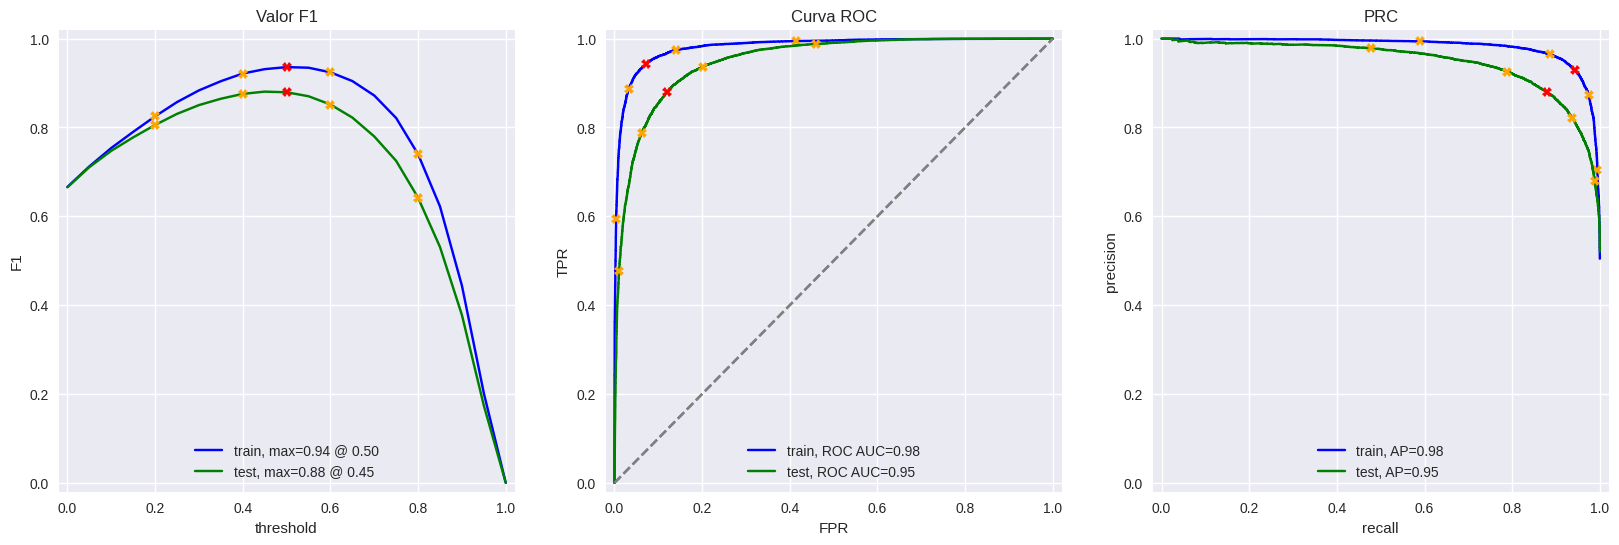

In [129]:
# Evaluate the recommended model on both train and test datasets
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

El objetivo del proyecto para **Film Junky Union** era desarrollar un modelo que clasificara automáticamente las reseñas de películas de IMDB como positivas o negativas, con un requisito mínimo de una puntuación F1 de 0.85 en el conjunto de prueba. Los resultados mostraron que un F1 de 0.88 fue alcanzado por el modelo en el conjunto de prueba, superando así el objetivo establecido. Además, métricas como **Accuracy**, **APS** y **ROC AUC** también fueron obtenidas con valores altos, lo que confirma que el modelo es considerado robusto y confiable para filtrar críticas negativas en la plataforma de la comunidad.

En resumen, los requisitos del proyecto fueron cumplidos por el modelo, el cual es considerado adecuado para ser utilizado por **Film Junky Union** con el fin de automatizar la clasificación de reseñas, contribuyendo a la mejora de la experiencia de los usuarios en su plataforma.